In [11]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from matplotlib.patches import  Polygon
from matplotlib.collections import PatchCollection

from datetime import datetime
from glob import glob

from utils import fileio
from utils import matrices
from utils import geometry
from utils import mechanics
from utils import visualise

In [4]:
def make_polygon(i, C, R, cell_centres):
    """
    Generate polygon

    Parameters:
    i (int): cell id
    C (numpy array): Nc x Nv order array relating cells to vertices
    R (numpy array): vertex coordinates
    cell_centres (numpy array): cell centre coordinates
    """

    Ralpha=R[np.where(C[i,:]==1)[0]]-cell_centres[i] #ref frame of cell
    ang=np.arctan2(Ralpha[:,1], Ralpha[:,0])%(2*np.pi) #find angle with x axis
    R_ang=np.transpose(np.vstack((np.where(C[i,:]==1)[0], ang))) #stack index of vertices with angle
    ordered_vertices=R_ang[np.argsort(R_ang[:,-1], axis=0)] #sort by anticlockwise angle
    polygon = Polygon(R[ordered_vertices[:,0].astype(int)],closed = True)
    return polygon

def plot_edges(A, R):
    N_e=np.shape(A)[0]
    beg_edge = ((abs(A) - A)*0.5)@R
    end_edge = ((abs(A) + A)*0.5)@R
    for j in range(0,N_e):
        if (beg_edge[j,0]!=0) and (end_edge[j, 0]!=0):
            plt.plot([beg_edge[j,0],end_edge[j,0]],[beg_edge[j,1],end_edge[j,1]],'k',alpha=1.0,linestyle ='-')

def plot_cell_centres(cell_centres):
    for i in range(len(cell_centres)):
        plt.plot(cell_centres[i,0],cell_centres[i,1],'k',marker ='o',markersize=1)
        
def plot_cell_id(cell_centres):
    for i in range(len(cell_centres)):
        plt.text(cell_centres[i][0], cell_centres[i][1], str(i),fontsize= 7,color='w', horizontalalignment='center', verticalalignment='center')

def plot_alignment_axis(cell_centres,alignment_axis):
    for i in range(len(cell_centres)):
            plt.quiver(cell_centres[i,0],cell_centres[i,1],np.cos(alignment_axis)[i],np.sin(alignment_axis)[i],facecolor = 'black',scale=110,width=0.002,headwidth=0.0,headlength=0.0,headaxislength=0.0)
            plt.quiver(cell_centres[i,0],cell_centres[i,1],-np.cos(alignment_axis)[i],-np.sin(alignment_axis)[i],facecolor = 'black',scale=110,width=0.002,headwidth=0.0,headlength=0.0,headaxislength=0.0)



def plot_polys(C, R, cell_centres):
    N_c=np.shape(C)[0]
    patches = []

    for i in range(N_c):
        polygon = make_polygon(i, C, R, cell_centres)
        patches.append(polygon)

    p = PatchCollection(patches,alpha = 1.0)
    return p

def plot_binary_polys(C, R, cell_centres, plot_var, threshold):
    N_c=np.shape(C)[0]
    patches = []
    patchesLow = []
    patchesHigh = []

    for i in range(N_c):
        polygon = make_polygon(i, C, R, cell_centres)
        patches.append(polygon)
        
        if plot_var[i] < threshold:
            polygonLow = polygon
            patchesLow.append(polygonLow)
        else:
            polygonHigh = polygon
            patchesHigh.append(polygonHigh)


    ### For binary effective pressure
    p_low = PatchCollection(patchesLow,alpha = 0.5)
    p_high = PatchCollection(patchesHigh,alpha = 0.7)
   
    return p_low, p_high


In [2]:
CURRENT_DIR = os.getcwd()
input_dir=CURRENT_DIR+'/Input/'

conf_file=(input_dir+'20190606_1_EJ_GFPTub-CheHis_uf_8p6_MP_fr1_trace_conf.csv')
#Path to directory where Matrices are stored
indata_dir="C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Code\\tissue_image_analysis\\tissue_image_analysis\\Output\\20190606_1_EJ_GFPTub-CheHis_uf_8p6_MP_fr1\\2023-05-25_16-58-30\\Matrices"

In [3]:
Lambda = -0.259 # Line tension (tunes P_0) (non-dimensional)
Gamma = 0.172  # Contractility (non-dimensional)
pref_perimeter  = -Lambda/(2*Gamma)  # Cell preferred perimeter (non-dimensional)
area_scaling = 0.00001785     # Gradient of the change in prefArea, used for time scaling. NB: if running code for knock downs you may need to recalculate this number.
t_relax = 20.0 #computational parameter not important for image analysis                                  # not needed, take out if want to
ExperimentFlag = 1   

#########################
#Setup directories and load Matrices
#########################

#read in conf file
edges_name,t_min, pixel_size, micron_size = fileio.read_conf(conf_file)
exp_id=edges_name.split('_')[0]+'_'+edges_name.split('_')[1]+'_'+edges_name.split('_')[4]+'_'+edges_name.split('_')[5]+'_'+edges_name.split('_')[7]
t=t_min*60.0
stretch_type=edges_name.split('_')[4][-1]
stretch_len=edges_name.split('_')[5]
frame=edges_name.split('_')[7][2:]
print(exp_id)

#make directories to output to
# if os.path.exists(output_dir+edges_name.split('_trace')[0])==False: os.mkdir(output_dir+edges_name.split('_trace')[0])

# mydir = os.path.join(output_dir+edges_name.split('_trace')[0], datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
# os.mkdir(mydir)
# data_dir=mydir+"/Data"
# plot_dir=mydir+"/Plots"
# if os.path.exists(data_dir)==False: os.mkdir(data_dir)
# if os.path.exists(plot_dir)==False: os.mkdir(plot_dir)



A  = np.loadtxt(glob(indata_dir+'/*Matrix_A.txt')[0]) # Incidence matrix. Rows => edges; columns => vertices.
B  = np.loadtxt(glob(indata_dir+'/*Matrix_B.txt')[0]) # Incidence matrix. Rows => cells; columns => edges. Values +/-1 for orientation
C  = np.loadtxt(glob(indata_dir+'/*Matrix_C.txt')[0]) # Incidence matrix. Rows => cells; columns => vertices. 
R  = np.loadtxt(glob(indata_dir+'/*Matrix_R.txt')[0]) # Coordinates of vertices

##############################
#Get cell geometry
##############################
R=R*(micron_size/pixel_size)

cell_areas=geometry.get_areas(A,B, R)
#print(cell_areas)
cell_perimeters=geometry.get_perimeters(A,B,R)
cell_edge_count=geometry.get_edge_count(B)
cell_centres=geometry.get_cell_centres(C,R,cell_edge_count)
mean_cell_area=geometry.get_mean_area(cell_areas)   
tangents=geometry.get_tangents(A,R)   
edge_lengths=geometry.get_edge_lengths(tangents)
print("Mean area = ", mean_cell_area)

20190606_1_uf_8p6_fr1
Mean area =  499.34534634851116


In [5]:
N_c=np.shape(C)[0]
N_v=np.shape(C)[1]
shape_tensor=np.zeros((N_c, 2, 2))
U=np.zeros((N_c, 2, 2))
s=np.zeros((N_c, 2))

circularity =np.zeros((N_c))
eigen_val_store = np.zeros((N_c,2))
eigen_vector_store1 = np.zeros((N_c,2))
eigen_vector_store2 = np.zeros((N_c,2))
Ralpha=np.zeros_like(R)

for i in range(N_c):
    R_temp=[]
    for k in range(N_v):
        Ralpha[k]=R[k]-cell_centres[i]

        if C[i,k]==1.0:
            shape_tensor[i] += (1.0/cell_edge_count[i])*np.outer(Ralpha[k],Ralpha[k])
            R_temp.append(Ralpha[k])
    R_temp=np.array(R_temp)
        
    eigvals, eigvecs = np.linalg.eig(shape_tensor[i])
    eigvals = eigvals.real
    if eigvals[0] > eigvals[1]:
        eigen_val_store[i,0]= eigvals[0]
        eigen_val_store[i,1]= eigvals[1]
        eigen_vector_store1[i] = eigvecs[:,0]
        eigen_vector_store2[i] = eigvecs[:,1]

    else:
        eigen_val_store[i,0]= eigvals[1]
        eigen_val_store[i,1]= eigvals[0]
        eigen_vector_store2[i] = eigvecs[:,0]
        eigen_vector_store1[i] = eigvecs[:,1]

    U[i],s[i],V=np.linalg.svd(R_temp.T, full_matrices=False)

    circularity[i] = abs(eigen_val_store[i][1]/eigen_val_store[i][0])

In [6]:
circ_svd=s[:,1]/s[:,0]

In [7]:
circ_IQ=4*np.pi*cell_areas/(cell_perimeters**2)

In [8]:
N_c=np.shape(B)[0] #number of cells
N_e=np.shape(B)[1] #number of edges

J=np.zeros((N_c,2,2))
for i in range(N_c):
    Q = np.zeros((2,2))
    for j in range(N_e):
        if abs(B[i,j])==1:#makes sure we are in the cell i
            that=(tangents[j]/edge_lengths[j])
            Q+=abs(B)[i,j]*edge_lengths[j]*np.outer(that,that)
    Q=Q/(cell_perimeters[i])

    J[i]=Q-0.5*np.identity(2)


detJ = np.linalg.det(J)

cell_zetas = np.sqrt(-detJ)

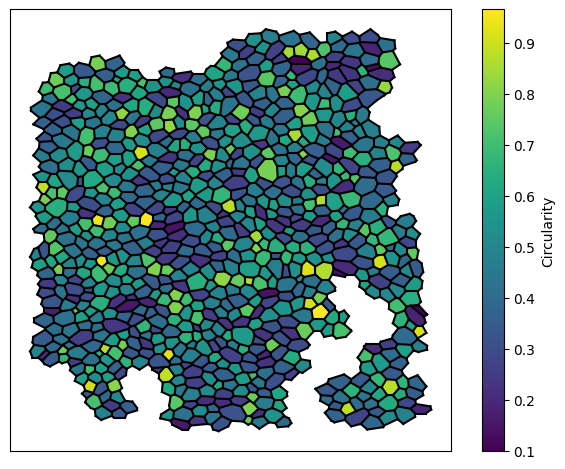

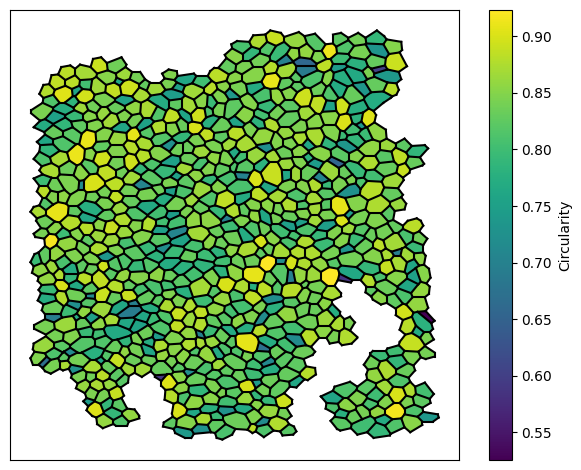

In [15]:
plot_variable=df_circ['circ_eigen'] ###Set variable to plot

fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})

#R=R-np.mean(R, axis=0)
## For colormap of continuous data

polys=plot_polys(C, R, cell_centres)
#polys.set_facecolor('black')
polys.set_array(plot_variable)
polys.set_cmap('viridis') ###set polygon colourmap here
#polys.set_clim(0,np.pi)
ax.add_collection(polys) 
cbar = fig.colorbar(polys, ax=ax)
cbar.ax.set_ylabel('Circularity', rotation=90) ###set colorbar label
ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

## Add edges to plot 
plot_edges(A,R)


plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()
plot_variable=df_circ['circ_IQ'] ###Set variable to plot

fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})

#R=R-np.mean(R, axis=0)
## For colormap of continuous data

polys=plot_polys(C, R, cell_centres)
#polys.set_facecolor('black')
polys.set_array(plot_variable)
polys.set_cmap('viridis') ###set polygon colourmap here
#polys.set_clim(0,np.pi)
ax.add_collection(polys) 
cbar = fig.colorbar(polys, ax=ax)
cbar.ax.set_ylabel('Circularity', rotation=90) ###set colorbar label
ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

## Add edges to plot 
plot_edges(A,R)


plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()

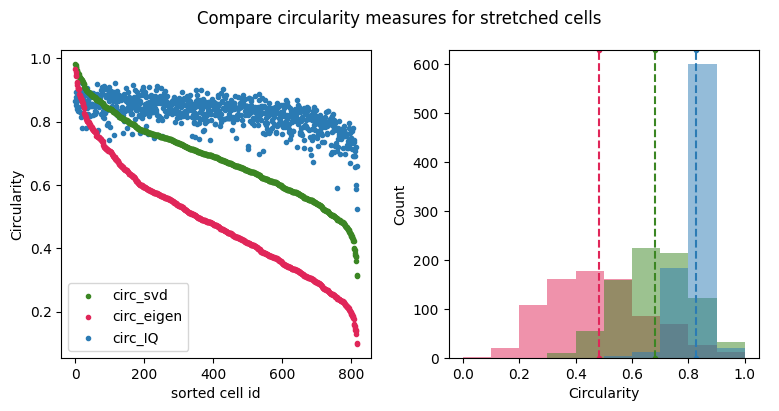

In [175]:
fig, axs = plt.subplots(1, 2, sharex=False, sharey=False,figsize=(9, 4))
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)


axs[0].scatter(df_s_eigen.cell_id, df_s_eigen.circ_svd, label='circ_svd',color=sns.husl_palette(3,l=.5)[1], marker='.')
axs[0].scatter(df_s_eigen.cell_id, df_s_eigen.circ_eigen, label='circ_eigen',color=sns.husl_palette(3,l=.5)[0], marker='.')
axs[0].scatter(df_s_eigen.cell_id, df_s_eigen.circ_IQ, zorder=0, label='circ_IQ',color=sns.husl_palette(3,l=.5)[2], marker='.')
axs[0].legend()
axs[0].set_ylabel('Circularity')
axs[0].set_xlabel('sorted cell id')


axs[1].hist(circularity, range=(0,1), alpha=0.5, color=sns.husl_palette(3,l=.5)[0])
axs[1].hist(circ_svd, range=(0,1), alpha=0.5,color=sns.husl_palette(3,l=.5)[1])
axs[1].hist(circ_IQ, range=(0,1), alpha=0.5, color=sns.husl_palette(3,l=.5)[2])
axs[1].axvline(df_circ.circ_svd.mean(),color=sns.husl_palette(3,l=.5)[1], marker='.', linestyle='--')
axs[1].axvline(df_circ.circ_eigen.mean(),color=sns.husl_palette(3,l=.5)[0], marker='.', linestyle='--')
axs[1].axvline(df_circ.circ_IQ.mean(),color=sns.husl_palette(3,l=.5)[2], marker='.', linestyle='--')
axs[1].set_ylabel('Count')
axs[1].set_xlabel('Circularity')


plt.suptitle('Compare circularity measures for stretched cells')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
# axs[2,3].set_xticks([])
# axs[2,3].set_yticks([])
# axs[2,3].axis('off')
plt.savefig('compare_circ_stretched.png', dpi=300, bbox_inches='tight')

(array([  0.,   0.,   0.,   0.,   0.,   0.,   4., 126., 665.,  43.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

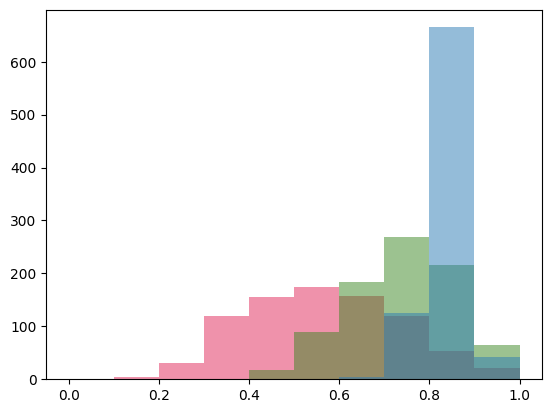

In [156]:

plt.hist(circularity, range=(0,1), alpha=0.5, color=sns.husl_palette(3,l=.5)[0])
plt.hist(circ_svd, range=(0,1), alpha=0.5,color=sns.husl_palette(3,l=.5)[1])
plt.hist(circ_IQ, range=(0,1), alpha=0.5, color=sns.husl_palette(3,l=.5)[2])

array([[1275.05651367,  347.38158203],
       [1313.09275065,  358.81652669],
       [1258.44575195,  375.13496652],
       [1296.48198893,  386.56991118]])

In [9]:
df_circ = pd.DataFrame({'cell_id': np.linspace(0, N_c-1,N_c), 'circ_eigen': circularity, 'circ_svd': circ_svd, 'circ_IQ': circ_IQ, 'strain':cell_zetas})

In [176]:
df_s_eigen=df_circ.sort_values(by=['circ_eigen'],ascending=False)
df_s_eigen['cell_id']=np.linspace(0, N_c-1,N_c)

df_s_IQ=df_circ.sort_values(by=['circ_IQ'],ascending=False)
df_s_IQ['cell_id']=np.linspace(0, N_c-1,N_c)


Text(0.5, 1.0, 'Compare circularity measures for stretched cells')

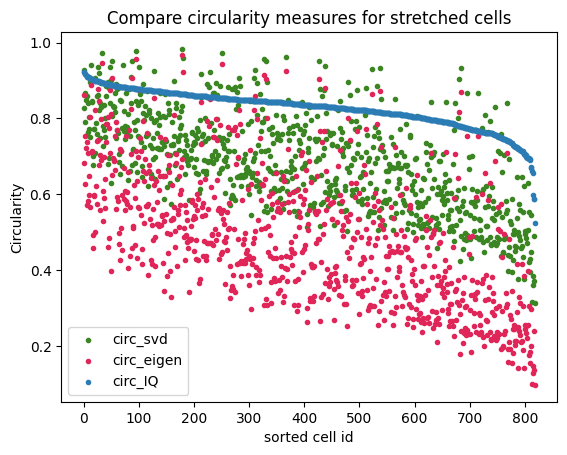

In [177]:

plt.scatter(df_s_IQ.cell_id, df_s_IQ.circ_svd, label='circ_svd',color=sns.husl_palette(3,l=.5)[1], marker='.')
plt.scatter(df_s_IQ.cell_id, df_s_IQ.circ_eigen, label='circ_eigen',color=sns.husl_palette(3,l=.5)[0], marker='.')
plt.scatter(df_s_IQ.cell_id, df_s_IQ.circ_IQ, label='circ_IQ',color=sns.husl_palette(3,l=.5)[2], marker='.')
plt.legend()
plt.ylabel('Circularity')
plt.xlabel('sorted cell id')
plt.title('Compare circularity measures for stretched cells')
#plt.savefig('compare_circ_stretched.png', dpi=300, bbox_inches='tight')

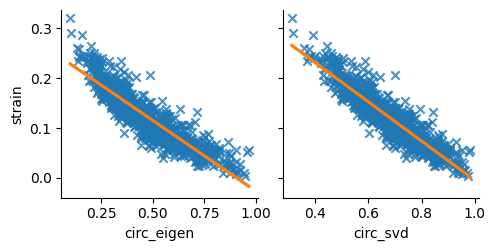

In [189]:
sns.pairplot(df_circ,    y_vars=["strain"],
    x_vars=["circ_eigen", "circ_svd"], diag_kws=dict(fill=False, bins=10, binrange=(0,1)), kind='reg', plot_kws=dict(line_kws={"color": "C1"}, marker='x'))